In [21]:
#import all libraries
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import os,sys
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

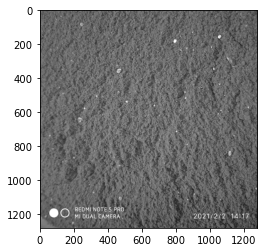

In [22]:
img = cv2.imread('10_per_adul/IMG-20210202-WA0093.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(gray,cmap='gray')
                  

In [3]:
def crop_photo_contour(image, plot=False):
    # convert umage to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.erode(gray, None, iterations=2)
    thresh = cv2.dilate(gray, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(gray.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image,cmap='gray')
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image,cmap='gray')

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

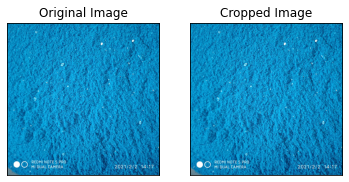

In [4]:
ex_img = cv2.imread('10_per_adul/IMG-20210202-WA0093.jpg')
ex_new_img = crop_photo_contour(ex_img,True)

In [5]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(os.path.join(directory,filename))
            # load the image
            # crop the photo and ignore the unnecessary rest part of the image
            #image = crop_photo_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array
            if directory == '10_per_adul':
                y.append([1])
            elif directory == '15_per_adul':
                y.append([2])
            elif directory == '20_per_adul':
                y.append([3])
            elif directory == '25_per_adul':
                y.append([4])
            elif directory == '30_per_adul':
                y.append([5])
            elif directory == 'pure':
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
      
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [6]:
ten_per = '10_per_adul'
fifteen_per= '15_per_adul'
twenty_per= '20_per_adul'
twentyfive_per= '25_per_adul'
thirty_per= '30_per_adul'
pure= 'pure'

IMG_WIDTH, IMG_HEIGHT = (150, 150)

X, y = load_data([ten_per,fifteen_per,twenty_per,twentyfive_per,thirty_per,pure], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 278
X shape is: (278, 150, 150, 3)
y shape is: (278, 1)


In [7]:
def plot_sample_images(X, y, n=5):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1,2,3,4,5]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 5
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        if (label == 1):
            label_to_str="10_per_adultered"
        elif (label==2):
            label_to_str="15_per_adultered"
        elif (label==3):
            label_to_str="20_per_adultered"
        elif (label==4):
            label_to_str="25_per_adultered"
        elif (label==5):
            label_to_str="30_per_adultered"
        else:
            label_to_str="pure"
            
        
        plt.suptitle(f"Turmeric powder: {label_to_str}")
        plt.show()

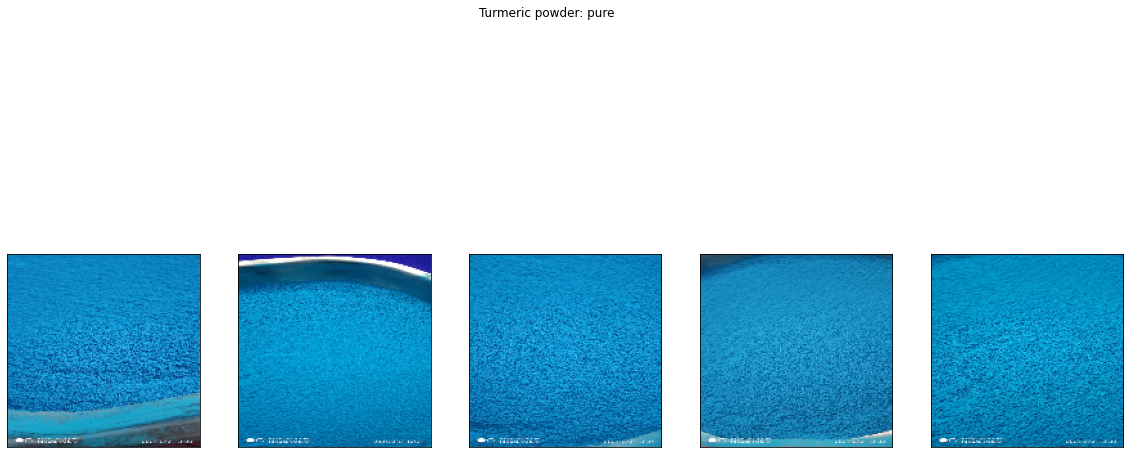

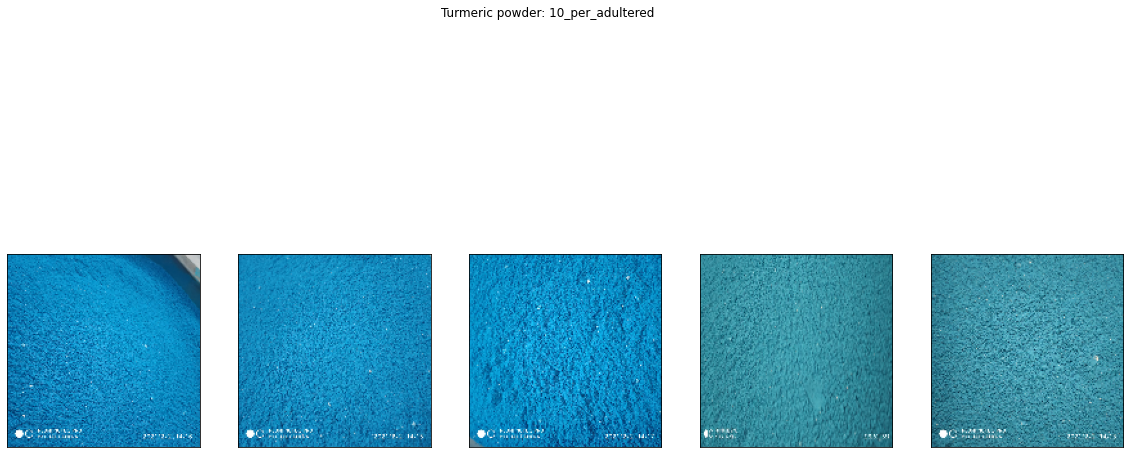

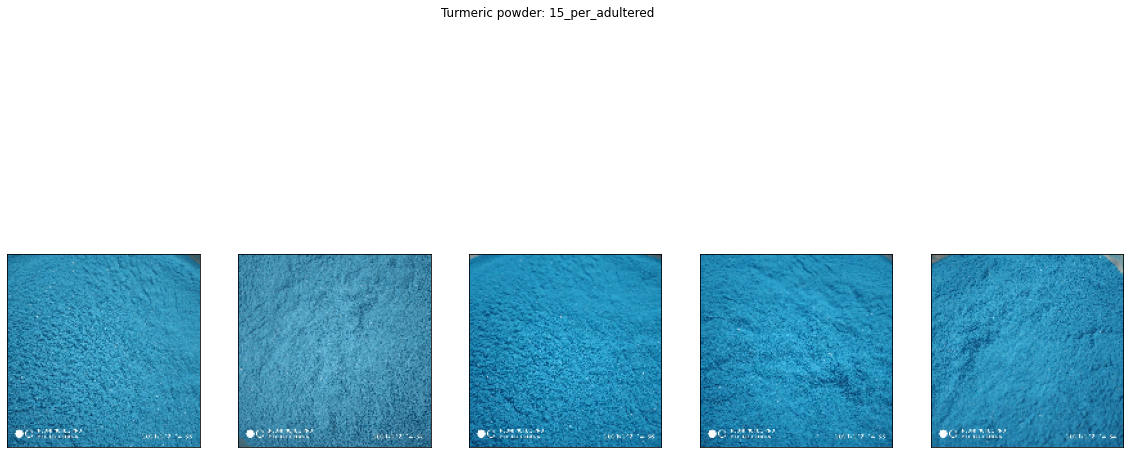

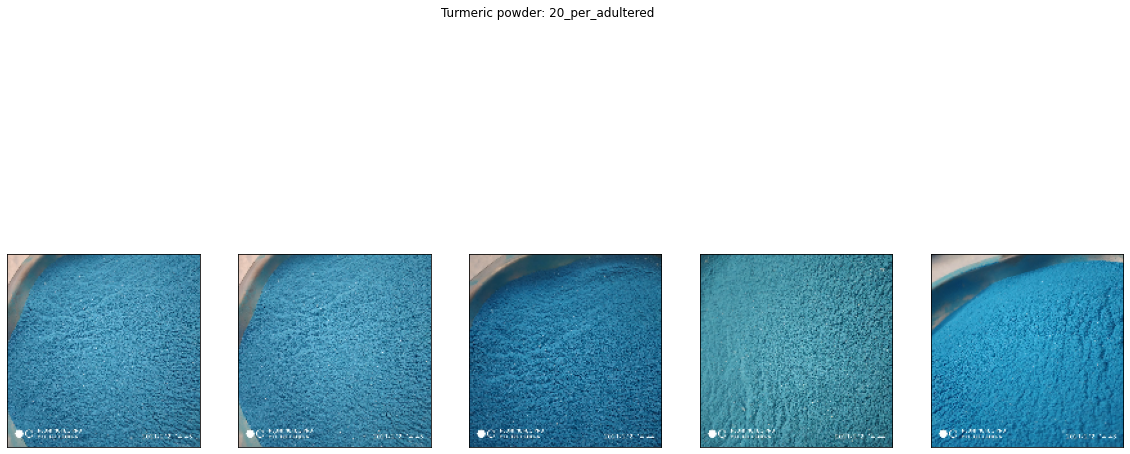

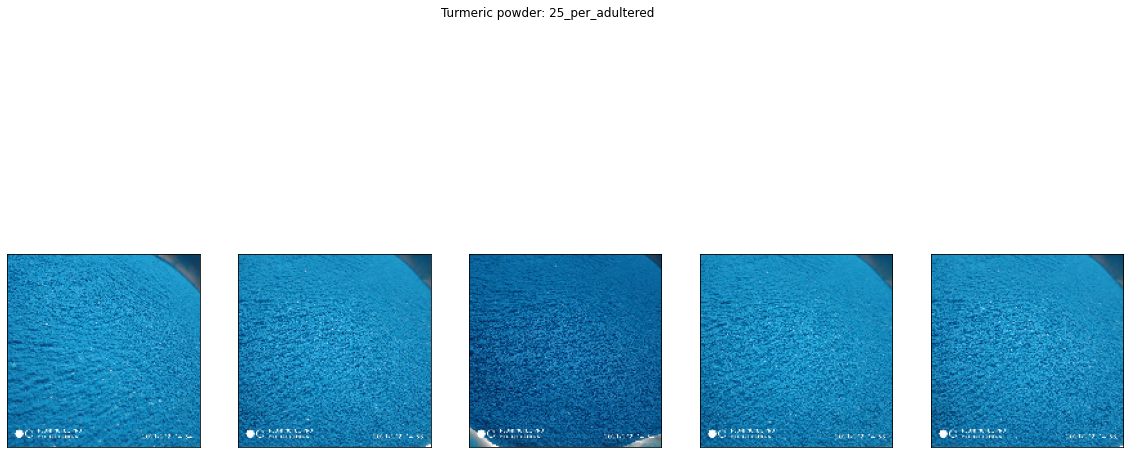

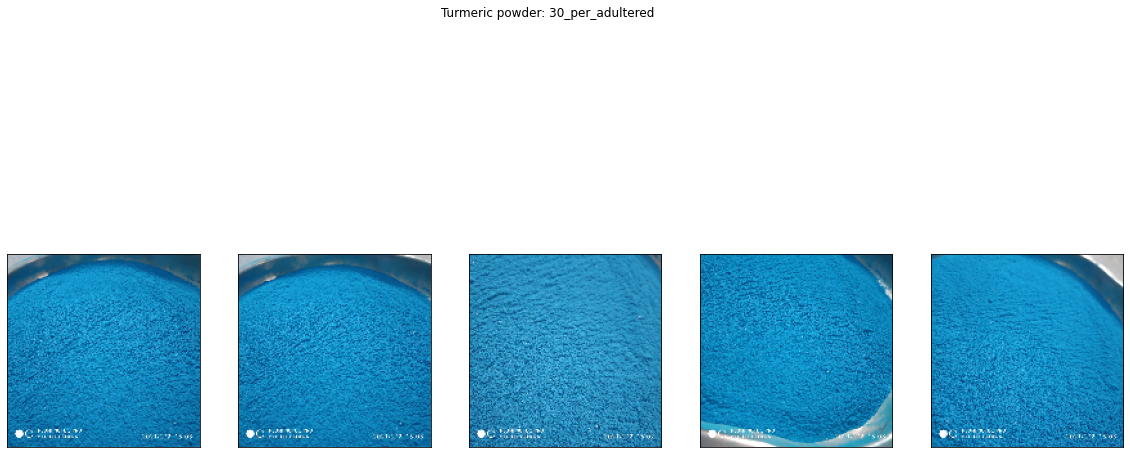

In [8]:
plot_sample_images(X, y)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [10]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 222
number of test examples = 56
X_train shape: (222, 150, 150, 3)
Y_train shape: (222, 1)
X_test shape: (56, 150, 150, 3)
Y_test shape: (56, 1)


In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])




In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [13]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
model.fit(x=X_train, y=y_train, batch_size=1, epochs=1, validation_data=(X_test, y_test))

222/222 [==============================] - 16s 70ms/step - loss: 1.8663 - accuracy: 0.2387 - val_loss: 1.7024 - val_accuracy: 0.1607


In [15]:
model.fit(x=X_train, y=y_train, batch_size=1, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
222/222 [==============================] - 16s 70ms/step - loss: 1.6531 - accuracy: 0.4009 - val_loss: 1.5480 - val_accuracy: 0.3750
Epoch 2/10
222/222 [==============================] - 16s 71ms/step - loss: 1.2205 - accuracy: 0.5541 - val_loss: 1.1438 - val_accuracy: 0.4643
Epoch 3/10
222/222 [==============================] - 16s 72ms/step - loss: 1.0839 - accuracy: 0.5946 - val_loss: 0.8822 - val_accuracy: 0.5000
Epoch 4/10
222/222 [==============================] - 16s 72ms/step - loss: 0.7580 - accuracy: 0.7568 - val_loss: 0.5944 - val_accuracy: 0.7679
Epoch 5/10
222/222 [==============================] - 15s 69ms/step - loss: 0.7089 - accuracy: 0.7297 - val_loss: 0.6195 - val_accuracy: 0.7679
Epoch 6/10
222/222 [==============================] - 15s 69ms/step - loss: 0.4944 - accuracy: 0.8153 - val_loss: 0.7179 - val_accuracy: 0.7500
Epoch 7/10
222/222 [==============================] - 15s 69ms/step - loss: 0.3894 - accuracy: 0.8649 - val_loss: 0.3661 - val_accuracy:

In [16]:
model.save('CNNmodel3.h5')

In [17]:
history = model.history.history

In [18]:
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


In [19]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

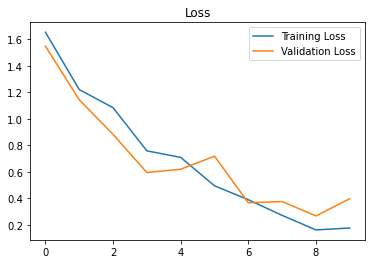

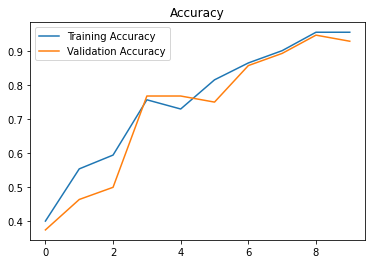

In [20]:
plot_metrics(history)